<a href="https://colab.research.google.com/github/NikolasGialitsis/usCensus/blob/master/Course_Project_N_09_US_Census_Demographic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!/usr/bin/env python
#@Author: Nikolas Gialitsis #
import pandas as pd
import copy
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import sys
from scipy.optimize import curve_fit
csv_file = "usCensus.csv"
header_num = 0
dataset = ''
while True:
    dataset=pd.read_csv(csv_file,delimiter= ",",header= header_num,error_bad_lines=False)
    if list(dataset)[0] == '%':
        header_num += 1
    else:
        break
print(header_num)

0


In [12]:
'''

CensusTract   1001020100
State Alabama
County Autauga
TotalPop 1948
Men 940
Women 1008
Hispanic 0.9
White 87.4
Black 7.7
Native 0.3
Asian 0.6
Pacific 0.0
Citizen 1503
Income 61838.0
IncomeErr 11900.0
IncomePerCap 25713.0
IncomePerCapErr 4548.0
Poverty 8.1
ChildPoverty 8.4
Professional 34.7
Service 17.0
Office 21.3
Construction 11.9
Production 15.2
Drive 90.2
Carpool 4.8
Transit 0.0
Walk 0.5
OtherTransp 2.3
WorkAtHome 2.1
MeanCommute 25.0
Employed 943
PrivateWork 77.1
PublicWork 18.3
SelfEmployed 4.6
FamilyWork 0.0
Unemployment 5.4
'''

'\n,,,,,,,,,,,,,,,,,,,,,,,,,,,,\n\nCensusTract   1001020100\nState Alabama\nCounty Autauga\nTotalPop 1948\nMen 940\nWomen 1008\nHispanic 0.9\nWhite 87.4\nBlack 7.7\nNative 0.3\nAsian 0.6\nPacific 0.0\nCitizen 1503\nIncome 61838.0\nIncomeErr 11900.0\nIncomePerCap 25713.0\nIncomePerCapErr 4548.0\nPoverty 8.1\nChildPoverty 8.4\nProfessional 34.7\nService 17.0\nOffice 21.3\nConstruction 11.9\nProduction 15.2\nDrive 90.2\nCarpool 4.8\nTransit 0.0\nWalk 0.5\nOtherTransp 2.3\nWorkAtHome 2.1\nMeanCommute 25.0\nEmployed 943\nPrivateWork 77.1\nPublicWork 18.3\nSelfEmployed 4.6\nFamilyWork 0.0\nUnemployment 5.4\n'

In [0]:
def GetFields(dataset):
  men = dataset['Men']
  women = dataset['Women']
  hispanic = dataset['Hispanic']
  total = dataset['TotalPop']
  white = dataset['White']
  black = dataset['Black']
  native = dataset['Native']
  asian = dataset['Asian']
  pacific = dataset['Pacific']
  profes = dataset['Professional']
  service = dataset['Service']
  office = dataset['Office']
  constr = dataset['Construction']
  product = dataset['Production']
  poverty = dataset['Poverty']
  child_pov = dataset['ChildPoverty']
  drive = dataset['Drive']
  carpool = dataset['Carpool']
  transit = dataset['Transit']
  walk = dataset['Walk']
  othertp = dataset['OtherTransp']
  workhome = dataset['WorkAtHome']
  private = dataset['PrivateWork']
  public = dataset['PublicWork']
  selfw  = dataset['SelfEmployed']
  family = dataset['FamilyWork']
  unemp = dataset['Unemployment']

  return(men,women,hispanic,total,white,black,native,asian,pacific,profes,
    service,office,constr,product,poverty,child_pov,
    drive,carpool,transit,walk,othertp,workhome, 
    private , public , selfw, family , unemp)

def Assess_Data_Integrity(dataset,epsilon):

  (men,women,hispanic,total,white,black,native,asian,pacific,profes,
  service,office,constr,product,poverty,child_pov,
  drive,carpool,transit,walk,othertp,workhome, 
  private , public , selfw, family , unemp) = GetFields(dataset)
  
  genders_err = []
  ethnic_err = []
  workspace_err = []
  job_err = []
  transp_err = []
  for x in range(0,total.size-1): 
    genders = men[x] + women[x]
    ethnic = hispanic[x] + white[x] + black[x] + native[x] + asian[x] + pacific[x]
    workspace =  profes[x] + service[x] +  office[x] + constr[x] + product[x]
    job = public[x] + private[x] + selfw[x] + family[x]
    transp = drive[x] + carpool[x] + walk[x] + transit[x] +othertp[x] + workhome[x] 

    if not math.isnan(genders) and genders != total[x] :
      genders_err.append(x)
    if not math.isnan(ethnic) and abs(ethnic  - 100.0) > epsilon :
      ethnic_err.append(x)
    if  not math.isnan(workspace) and abs( workspace - 100.0) > epsilon :
      workspace_err.append(x)
    if not math.isnan(job) and abs( job - 100.0) > epsilon  :
      job_err.append(x)
    if not math.isnan(transp) and abs( transp - 100.0) > epsilon :
      transp_err.append(x)
  return(genders_err,ethnic_err,workspace_err,job_err,transp_err)



In [21]:
genders_err,ethnic_err,workspace_err,job_err,transp_err = Assess_Data_Integrity(dataset,0.05)
num_rows = dataset['TotalPop'].size
print('genders_err = ',len(genders_err), ' / ', num_rows)
print('ethnic_err = ' , len(ethnic_err), ' / ', num_rows)
print('workspace_err = ' ,len(workspace_err), ' / ',num_rows)
print('job_err = ' , len(job_err), ' / ', num_rows)
print('transp_err = ' , len(transp_err), ' / ', num_rows)




genders_err =  0  /  74001
ethnic_err =  58446  /  74001
workspace_err =  0  /  74001
job_err =  0  /  74001
transp_err =  0  /  74001


In [0]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


X = dataset[['TotalPop','Poverty']]
X= X[np.isfinite(X['TotalPop'])]
X= X[np.isfinite(X['Poverty'])]
wcss=[]
for i in range(1,20):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,20),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

#Fitting K-MEans to the dataset
kmeans=KMeans(n_clusters=3,init='k-means++',random_state=0)
y_kmeans=kmeans.fit_predict(X)

#Visualize the clusters




[[6612.20823096   14.92772727]
 [3246.31930825   17.97512411]]
[1 1 1 ... 1 0 1]


TypeError: ignored

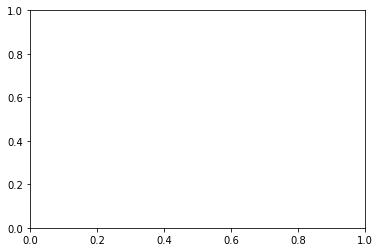

In [51]:
cent = kmeans.cluster_centers_
print(cent)
print(y_kmeans)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow')  
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')  
ax.set_title('K-Means Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Corruption')
plt.colorbar(scatter)